Importing necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate

Reading csv-files, and making dataframe of id sorted alphanumeric, corresponding to the images loaded. 

In [2]:
train_sample = pd.read_csv("data/train/train_sample_clean")
test_sample = pd.read_csv("data/test/test_sample_clean")
validate_sample = pd.read_csv("data/validate/validate_sample_clean")

In [3]:
id_train = pd.DataFrame({"id": pd.Series(glob.glob("data/train/images/*/*.jpg")).apply(lambda x: x.split("\\")[-1].split(".")[0])})
id_test = pd.DataFrame({"id": pd.Series(glob.glob("data/test/images/*/*.jpg")).apply(lambda x: x.split("\\")[-1].split(".")[0])})
id_validate = pd.DataFrame({"id": pd.Series(glob.glob("data/validate/images/*/*.jpg")).apply(lambda x: x.split("\\")[-1].split(".")[0])})

In [4]:
id_train

,id
0,101453
1,102h5n
2,103ckj
3,1056j4
4,105d08
...,...
34975,z5ebr
34976,zfafc
34977,zhgi0
34978,zwtld


In [5]:
train_sample.head()

,Unnamed: 0,clean_title,id,image_url,5_way_label,files
0,0,perfect execution modern us air force poster,100pp1,https://external-preview.redd.it/cBy5xWF292XdF...,4,data/train/images\5\100pp1.jpg
1,1,bill murray and a potted plant,101453,https://external-preview.redd.it/gPMI9k0_d0gDX...,0,data/train/images\0\101453.jpg
2,2,oh the things he has seen,1016df,https://external-preview.redd.it/adC8wXKw5Qqeu...,2,data/train/images\2\1016df.jpg
3,3,confidence methodically continuing his amputat...,1018ps,https://external-preview.redd.it/fY4bLZ-aBt3QW...,4,data/train/images\5\1018ps.jpg
4,4,retiring boss gives employees for each year th...,102h5n,https://external-preview.redd.it/0qHYWFvuxLzjk...,0,data/train/images\0\102h5n.jpg


Merging dataframes, making sure dataframe is sorted in same alphanumeric order as images are loaded, starting in folder 0, by alphanumeric order, and so on. 

In [6]:
train_df = id_train.merge(train_sample, how="inner", on="id")
test_df = id_test.merge(test_sample, how="inner", on="id")
validate_df = id_validate.merge(validate_sample, how="inner", on="id")

In [7]:
train_df

,id,Unnamed: 0,clean_title,image_url,5_way_label,files
0,101453,1,bill murray and a potted plant,https://external-preview.redd.it/gPMI9k0_d0gDX...,0,data/train/images\0\101453.jpg
1,102h5n,4,retiring boss gives employees for each year th...,https://external-preview.redd.it/0qHYWFvuxLzjk...,0,data/train/images\0\102h5n.jpg
2,103ckj,7,winnipeg transit drivers amazing act of kindne...,https://external-preview.redd.it/COLdMVpkBJbYh...,0,data/train/images\0\103ckj.jpg
3,1056j4,8,not expecting this to be popular a moth landed...,https://external-preview.redd.it/3QlaLMuDHkZnH...,0,data/train/images\0\1056j4.jpg
4,105d08,9,lawmakers victims want subway grinders labeled...,https://external-preview.redd.it/6gGXtK6WsHcQD...,0,data/train/images\0\105d08.jpg
...,...,...,...,...,...,...
34975,z5ebr,34924,welcome to baghdad poster by iraqifinnish arti...,https://external-preview.redd.it/6zf_JW3RCPggp...,4,data/train/images\5\z5ebr.jpg
34976,zfafc,34940,petty squabbles are taboo now if you must talk...,https://external-preview.redd.it/QK4qKqSYzXRnK...,4,data/train/images\5\zfafc.jpg
34977,zhgi0,34944,rd reich sa recruiting poster sa voran,https://external-preview.redd.it/bfCrZvwOO1Sos...,4,data/train/images\5\zhgi0.jpg
34978,zwtld,34970,scot towel advert is your washroom breeding bo...,https://external-preview.redd.it/lCZFiKSk2IFyz...,4,data/train/images\5\zwtld.jpg


Making vectorizer with same input as for text-model. 

In [8]:
max_words = 2**15 
max_sequence_length = 16

vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=max_sequence_length, output_mode="int")

In [9]:
vectorizer.adapt(train_df["clean_title"].values)

Making dataset of tokenized titles. 

In [10]:
tokenized_train = tf.data.Dataset.from_tensor_slices(vectorizer(train_df["clean_title"].values))
tokenized_test = tf.data.Dataset.from_tensor_slices(vectorizer(test_df["clean_title"].values))
tokenized_validate = tf.data.Dataset.from_tensor_slices(vectorizer(validate_df["clean_title"].values))

Loading images, with categorical labels, no batching and no shuffling, to make sure they are in same order as titles and labels. 

In [11]:
img_data_train = tf.keras.preprocessing.image_dataset_from_directory("data/train/images", label_mode="categorical", batch_size=None, shuffle=False)
img_data_test = tf.keras.preprocessing.image_dataset_from_directory("data/test/images", label_mode="categorical", batch_size=None, shuffle=False)
img_data_validate = tf.keras.preprocessing.image_dataset_from_directory("data/validate/images", label_mode="categorical", batch_size=None, shuffle=False)

Found 34980 files belonging to 5 classes.
Found 3710 files belonging to 5 classes.
Found 7334 files belonging to 5 classes.


Extracting images and labels as separate datasets, where images also are normalized. 

In [12]:
img_train = img_data_train.map(lambda x,y: x/255)
img_test = img_data_test.map(lambda x,y: x/255)
img_validate = img_data_validate.map(lambda x,y: x/255)

In [13]:
y_train = img_data_train.map(lambda x,y: y)
y_test = img_data_test.map(lambda x,y: y)
y_validate = img_data_validate.map(lambda x,y: y)

Creating dataset with multiple input and corresponding label, by zipping together. 

In [14]:
multimodal_data_train = tf.data.Dataset.zip((tokenized_train,img_train), y_train)
multimodal_data_test = tf.data.Dataset.zip((tokenized_test, img_test), y_test)
multimodal_data_validate = tf.data.Dataset.zip((tokenized_validate, img_validate), y_validate)

Checking shape of dataset, that it is actually one title, one image and one label pr. sample. 

In [15]:
multimodal_data_train.as_numpy_iterator().next()[0][0].shape, multimodal_data_train.as_numpy_iterator().next()[0][1].shape, multimodal_data_train.as_numpy_iterator().next()[1].shape

((16,), (256, 256, 3), (5,))

Shuffle test -and validation-sets before putting into batches of 16. 

In [16]:
multimodal_data_test = multimodal_data_test.shuffle(buffer_size=multimodal_data_test.cardinality()).batch(16)
multimodal_data_validate = multimodal_data_validate.shuffle(buffer_size=multimodal_data_validate.cardinality()).batch(16)

Sharding train-set, then shuffle, to avoid OOM. 

In [17]:
shard_1 = multimodal_data_train.shard(num_shards=5, index=0)
shard_2 = multimodal_data_train.shard(num_shards=5, index=1)
shard_3 = multimodal_data_train.shard(num_shards=5, index=2)
shard_4 = multimodal_data_train.shard(num_shards=5, index=3)
shard_5 = multimodal_data_train.shard(num_shards=5, index=4)

In [18]:
shard_1 = shard_1.shuffle(buffer_size=shard_1.cardinality())
shard_2 = shard_2.shuffle(buffer_size=shard_2.cardinality())
shard_3 = shard_3.shuffle(buffer_size=shard_3.cardinality())
shard_4 = shard_4.shuffle(buffer_size=shard_4.cardinality())
shard_5 = shard_5.shuffle(buffer_size=shard_5.cardinality())

Concatenating shards back together. 

In [19]:
multimodal_data_train = shard_5.concatenate(shard_3).concatenate(shard_2).concatenate(shard_4).concatenate(shard_1)

Batches of 16. 

In [20]:
multimodal_data_train = multimodal_data_train.batch(16)

Building model with Functional API, same parameters as before. 

In [21]:
text_in = Input(shape=(16,))

text = (Embedding(max_words+1, 32))(text_in)
text = (BatchNormalization())(text)

text_out = (Bidirectional(LSTM(32, activation="tanh", recurrent_activation="sigmoid")))(text)

In [22]:
img_in = Input(shape=(256,256,3))

img = (Conv2D(16,(3,3), 1, activation="relu"))(img_in)
img = (MaxPooling2D())(img)

img = (Conv2D(32,(3,3), 1, activation="relu"))(img)
img = (MaxPooling2D())(img)

img = (Conv2D(16,(3,3), 1, activation="relu"))(img)
img = (MaxPooling2D())(img)

img_out = (Flatten())(img)

Concatenate together, before going through 2 dense layers together. 

In [23]:
multimodal = Concatenate()([text_out, img_out])

multimodal = Dense(64, activation="relu")(multimodal)

multimodal_out = Dense(5, activation="softmax")(multimodal)

Final multimodal model. 

In [24]:
multimodal_model = Model([text_in, img_in], multimodal_out)

In [25]:
multimodal_model.compile("adam", loss=tf.losses.categorical_crossentropy, metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [26]:
multimodal_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 32)    │  1,048,608 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │      4,624 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 32)    │        128 │ embedding[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     16,640 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14400)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14464)     │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    925,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        325 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,001,173 (7.63 MB)

 Trainable params: 2,001,109 (7.63 MB)

 Non-trainable params: 64 (256.00 B)

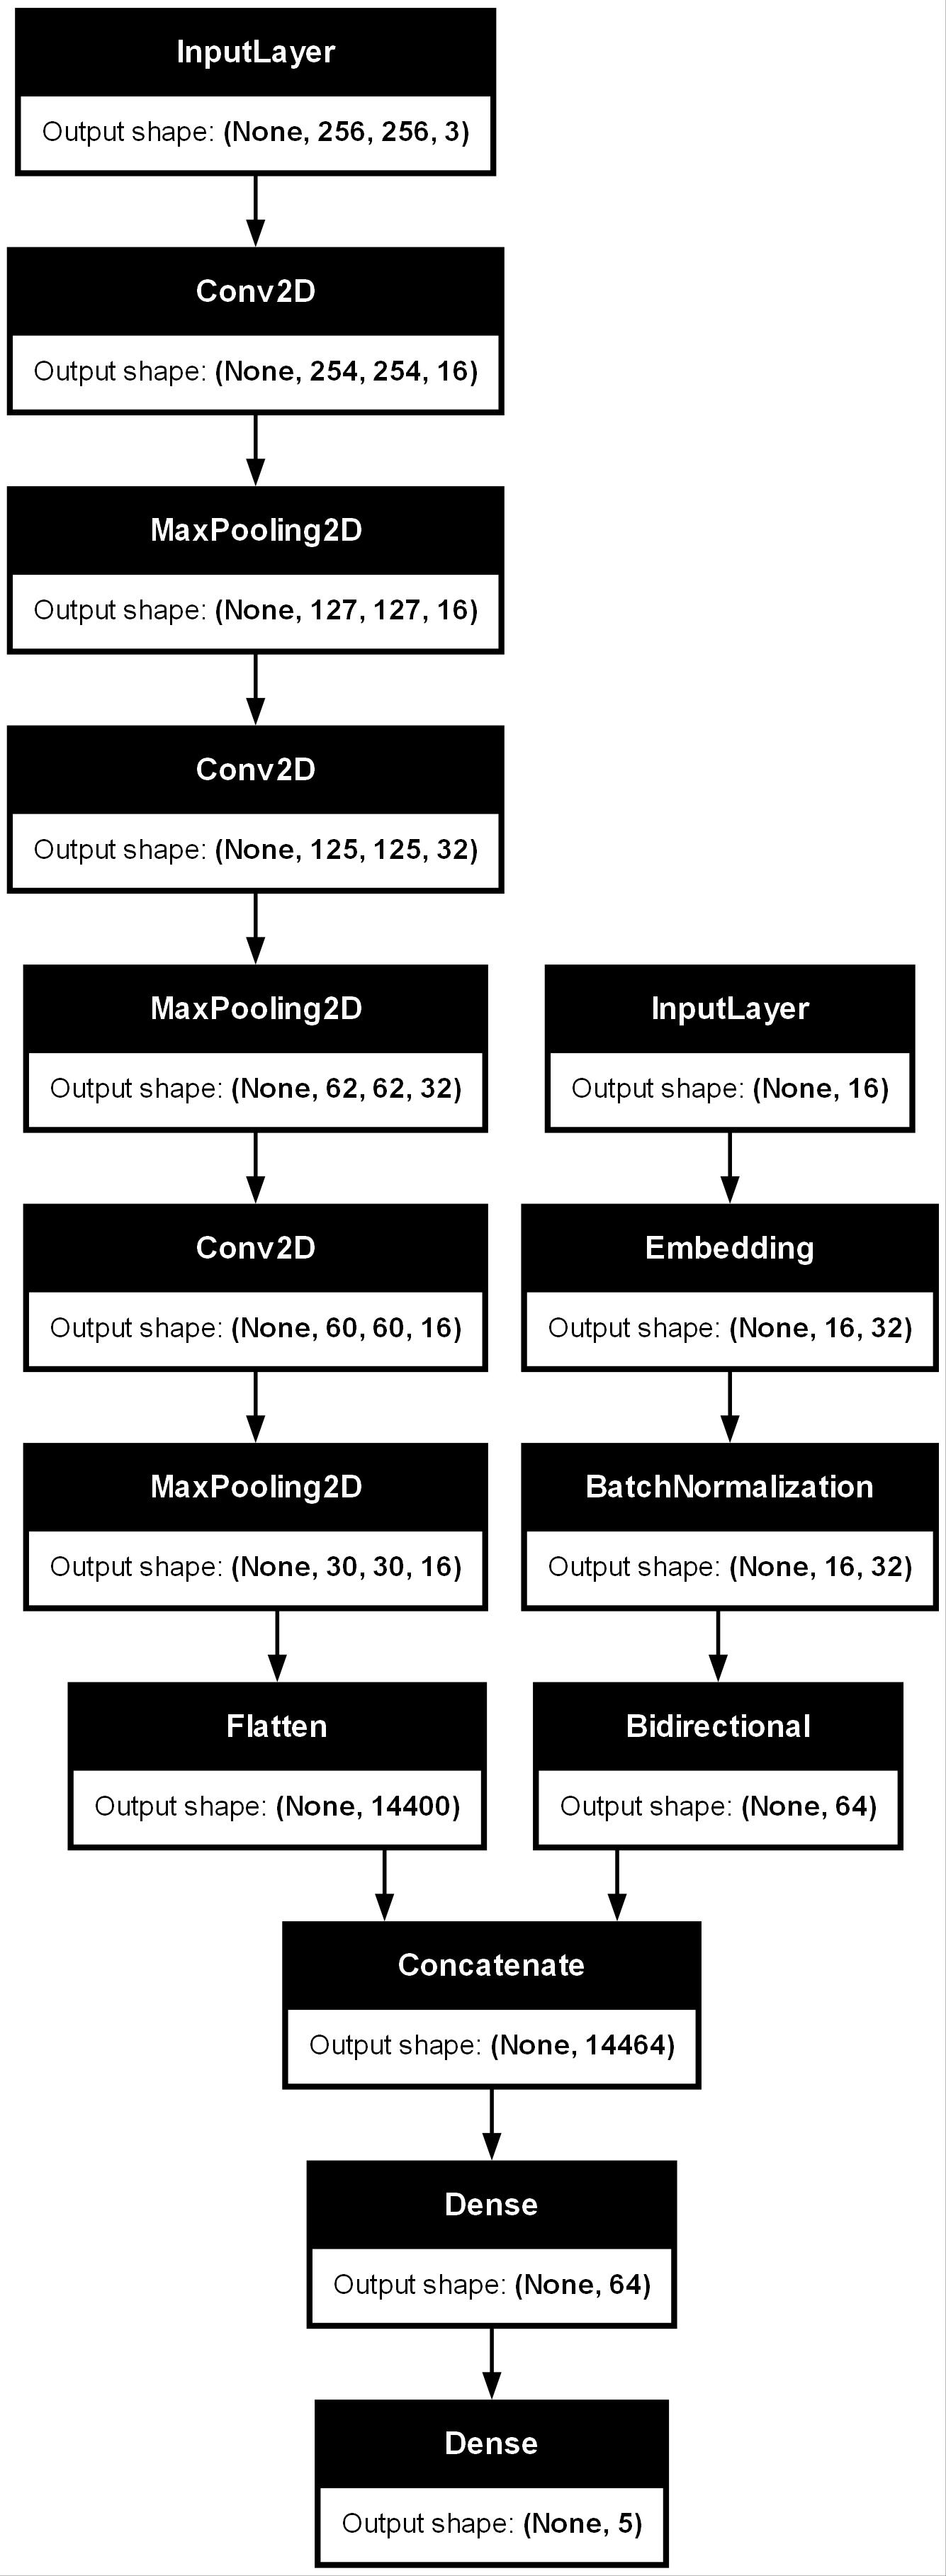

In [27]:
os.environ["PATH"] += os.pathsep + 'C:/Programfiler/Graphviz/bin/'
tf.keras.utils.plot_model(multimodal_model, to_file="multimodal_model.jpg", show_shapes=True)

Training for 1 epoch. 

In [28]:
history = multimodal_model.fit(multimodal_data_train,  epochs=1, validation_data=multimodal_data_validate)

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 769s 329ms/step - categorical_accuracy: 0.6472 - loss: 0.9409 - val_categorical_accuracy: 0.7355 - val_loss: 0.7194


Predicting label, getting confusion matrix -and F1-score. 

In [30]:
y_actual = []
y_predicted = []
for batch in multimodal_data_test.as_numpy_iterator():
    X, y = batch
    y_pred = multimodal_model.predict(X)
    y_actual.extend(y)
    y_predicted.extend(y_pred)

y_actual = np.argmax(np.array(y_actual), axis=-1)
y_predicted = np.argmax(np.array(y_predicted), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms

In [31]:
confusion_mat = tf.math.confusion_matrix(y_actual, y_predicted)
confusion_mat = np.array(confusion_mat)
confusion_mat

array([[2033,   63,  116,    5,   15],
       [ 118,  117,   32,    2,    4],
       [ 325,   47,  537,    3,   11],
       [  58,   10,    9,    5,    0],
       [  49,   19,   11,    6,  115]])

In [35]:
def get_accuracy(confusion_matrix):
    return confusion_matrix.trace()/confusion_matrix.sum()

In [36]:
accuracy = get_accuracy(confusion_mat)
accuracy

0.7566037735849057

In [39]:
def get_F1_score(confusion_matrix):
    recall = []
    precision = []

    for i in range(len(confusion_matrix)):
        recall.append(confusion_matrix[i,i]/confusion_matrix[i,:].sum())
        precision.append(confusion_matrix[i,i]/confusion_matrix[:,i].sum())

    recall = np.array(recall)
    precision = np.array(precision)

    return recall, precision, (2*recall*precision)/(recall+precision)

In [40]:
recall, precision, F1_score = get_F1_score(confusion_mat)
recall, precision, F1_score

(array([0.91084229, 0.42857143, 0.58179848, 0.06097561, 0.575     ]),
 array([0.7870693 , 0.45703125, 0.76170213, 0.23809524, 0.79310345]),
 array([0.84444444, 0.44234405, 0.65970516, 0.09708738, 0.66666667]))